# Characterizing Observational Database Research Using Python:<br> FDA Sentinel
Fall 2020 Associate Fellowship Project<br>
Amanda Sawyer, MLIS<br>
Project Sponsor: Vojtech Huser, MD, PhD

In [1]:
from Bio import Entrez
from Bio import Medline
import numpy as np
import pandas as pd
from csv import reader
import re
from ratelimiter import RateLimiter
import pubmed_parser as pp
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
from matplotlib import cm

In [2]:
Entrez.email = "Enter Email"
api_key = 'Enter MyNCBI API Key'

**1. Collecting Article Metadata with NCBI E-Utilities and Biopython**

In [3]:
#Create a DataFrame from the CSV file 
sentinelCSV = 'sentinel-publications.csv'
sentinel = pd.read_csv(sentinelCSV)
#remove presentations so we are left with just publications
sentinel = sentinel[sentinel.Type != 'Presentation']
sentinel = sentinel.reset_index()
sentinel = sentinel[['Title', 'Type', 'Author(s)', 'Date']]
sentinel

,Title,Type,Author(s),Date
0,The FDA MyStudies App: A Reusable Platform for...,Publication,"Zachary Wyner, Sascha Dublin, Christina Chambe...",12/11/2020
1,Incidence of Uterine Bleeding following Oral A...,Publication,"Abby Anderson, Audrey Gassman, Laura Hou, Ting...",11/26/2020
2,Leveraging the Capabilities of the FDA’s Senti...,Publication,"Sruthi Adimadhyam, Erin F. Barreto, Noelle M. ...",10/19/2020
3,Complementary Use of U.S. FDA’s Adverse Event ...,Publication,"Mohamed Mohamoud, Casie Horgan, Efe Eworuke, E...",10/08/2020
4,Phosphodiesterase Type 5 Inhibitor Use Among P...,Publication,"Wei Liu, Talia J. Menzin, Corinne M. Woods, Ni...",10/05/2020
...,...,...,...,...
173,A Systematic Review of Validated Methods for I...,Publication,"Gary Schneider ScD, MSPH; Sumesh Kachroo PhD, ...",01/19/2012
174,Mini-Sentinel's Systematic Reviews of Validate...,Publication,"Ryan M. Carnahan PharmD, MS, BCPP; Kevin G. Mo...",01/19/2012
175,A Systematic Review of Validated Methods for I...,Publication,"Gary Schneider ScD, MSPH; Sumesh Kachroo PhD, ...",01/19/2012
176,Effects of Adjusting for Instrumental Variable...,Publication,"Jessica A. Myers PhD, ScD; Jeremy A. Rassen Sc...",06/08/2011


In [4]:
#Defining a function to search PubMed for article title and returns PMID if title is found.
#Limit to 10 requests per second per NCBI guidelines

@RateLimiter(max_calls=10, period=1)
def getPMID(articleTitle) :   
    handle = Entrez.esearch(db="pubmed", retmax=1, term=articleTitle)
    record = Entrez.read(handle)
    handle.close()
    pmid = record['IdList']
    return pmid

In [5]:
#Apply the getPMID function to DataFrame to retreive PMIDs for articles in CSV that are listed in PubMed
#Convert PMID list to string in column
sentinel['PMID'] = sentinel['Title'].apply(getPMID)
sentinel['PMID'] = sentinel['PMID'].str[0]
sentinel.head()

,Title,Type,Author(s),Date,PMID
0,The FDA MyStudies App: A Reusable Platform for...,Publication,"Zachary Wyner, Sascha Dublin, Christina Chambe...",12/11/2020,NaN
1,Incidence of Uterine Bleeding following Oral A...,Publication,"Abby Anderson, Audrey Gassman, Laura Hou, Ting...",11/26/2020,33248974
2,Leveraging the Capabilities of the FDA’s Senti...,Publication,"Sruthi Adimadhyam, Erin F. Barreto, Noelle M. ...",10/19/2020,33077615
3,Complementary Use of U.S. FDA’s Adverse Event ...,Publication,"Mohamed Mohamoud, Casie Horgan, Efe Eworuke, E...",10/08/2020,33090530
4,Phosphodiesterase Type 5 Inhibitor Use Among P...,Publication,"Wei Liu, Talia J. Menzin, Corinne M. Woods, Ni...",10/05/2020,33020970


In [6]:
#Check for null values to determine what articles are not in PubMed.
check_nan = sentinel['PMID'].isnull().sum()
check_nan

19

In [7]:
#Create new dataframe that only includes publications with PMIDs, reset the index in order to find new number of publications
#208 publications removed
sentinel = sentinel[sentinel['PMID'].notna()]
sentinel = sentinel.reset_index()

In [8]:
#Defining a function to return PubMed metadata (MeSH) for PMIDs in DataFrame
#Limit to 10 requests per second per NCBI guidelines

@RateLimiter(max_calls=10, period=1)
def getMeshHeadings (pmid) :
    mesh = []
    handle = Entrez.efetch(db='pubmed', id=pmid, rettype='medline', retmode='text')
    records = Medline.parse(handle)
    for record in records:
        try :
            mesh = record['MH']
        except : pass
    return mesh

In [9]:
#Apply the getPMID function to DataFrame to retreive PMIDs for articles in CSV that are listed in PubMed
sentinel['MeSH'] = sentinel['PMID'].apply(getMeshHeadings)

In [10]:
#Explode on keywords, so that each term has it's own row.
#Reindex the DataFrame
sentinel = sentinel.explode('MeSH')

In [11]:
sentinel = sentinel.reset_index()
sentinel = sentinel.drop(columns={"index": "Article ID"})

In [12]:
#Split the descriptors from the qualifers into spearate columns in the DataFrame
descriptor = []
qualifier = []
   
for x, y in sentinel['MeSH'].iteritems():
    if pd.notnull(y):
        head, sep, tail = y.partition('/')
        descriptor.append(head)
        qualifier.append(tail)
    else:
        descriptor.append('')
        qualifier.append('')

sentinel['Descriptor'] = descriptor
sentinel['Qualifier'] = qualifier

In [13]:
sentinel

,level_0,Title,Type,Author(s),Date,PMID,MeSH,Descriptor,Qualifier
0,0,Incidence of Uterine Bleeding following Oral A...,Publication,"Abby Anderson, Audrey Gassman, Laura Hou, Ting...",11/26/2020,33248974,NaN,,
1,1,Leveraging the Capabilities of the FDA’s Senti...,Publication,"Sruthi Adimadhyam, Erin F. Barreto, Noelle M. ...",10/19/2020,33077615,NaN,,
2,2,Complementary Use of U.S. FDA’s Adverse Event ...,Publication,"Mohamed Mohamoud, Casie Horgan, Efe Eworuke, E...",10/08/2020,33090530,NaN,,
3,3,Phosphodiesterase Type 5 Inhibitor Use Among P...,Publication,"Wei Liu, Talia J. Menzin, Corinne M. Woods, Ni...",10/05/2020,33020970,NaN,,
4,4,Risk of Stroke and Bleeding in Atrial Fibrilla...,Publication,"Marie Bradley, Emily C. Welch, Efe Eworuke, Da...",09/28/2020,33529622,NaN,,
...,...,...,...,...,...,...,...,...,...
1612,158,Developing the Sentinel System — A National Re...,Publication,"Rachel E. Behrman MD, MPH; Joshua S. Benner Ph...",02/10/2011,21226658,Evidence-Based Medicine/*organization & admini...,Evidence-Based Medicine,*organization & administration
1613,158,Developing the Sentinel System — A National Re...,Publication,"Rachel E. Behrman MD, MPH; Joshua S. Benner Ph...",02/10/2011,21226658,Humans,Humans,
1614,158,Developing the Sentinel System — A National Re...,Publication,"Rachel E. Behrman MD, MPH; Joshua S. Benner Ph...",02/10/2011,21226658,"*Product Surveillance, Postmarketing","*Product Surveillance, Postmarketing",
1615,158,Developing the Sentinel System — A National Re...,Publication,"Rachel E. Behrman MD, MPH; Joshua S. Benner Ph...",02/10/2011,21226658,United States,United States,


**Data Cleaning for Comparison**

In [14]:
#Drop records from DataFrame where there are 0 MeSH terms - these are outside of the scope of this project.
sentinel = sentinel.dropna(subset=['MeSH'])

In [15]:
def remove_punctuation(x):
    x = x.replace('*','')
    return x

def lowercase(x):
    x = x.lower()
    return x

sentinel['MeSH Cleaned'] = sentinel['Descriptor'].apply(remove_punctuation)
sentinel['MeSH Cleaned'] = sentinel['MeSH Cleaned'].str.lower()

In [16]:
sentinel

,level_0,Title,Type,Author(s),Date,PMID,MeSH,Descriptor,Qualifier,MeSH Cleaned
8,8,Underuse of Oral anticoagulants in privately i...,Publication,"Sana M. Al-Khatib, Sean D. Pokorney, Hussein R...",07/24/2020,32949986,"Administration, Oral","Administration, Oral",,"administration, oral"
9,8,Underuse of Oral anticoagulants in privately i...,Publication,"Sana M. Al-Khatib, Sean D. Pokorney, Hussein R...",07/24/2020,32949986,Aged,Aged,,aged
10,8,Underuse of Oral anticoagulants in privately i...,Publication,"Sana M. Al-Khatib, Sean D. Pokorney, Hussein R...",07/24/2020,32949986,"Aged, 80 and over","Aged, 80 and over",,"aged, 80 and over"
11,8,Underuse of Oral anticoagulants in privately i...,Publication,"Sana M. Al-Khatib, Sean D. Pokorney, Hussein R...",07/24/2020,32949986,*Anticoagulants/administration & dosage/advers...,*Anticoagulants,administration & dosage/adverse effects/classi...,anticoagulants
12,8,Underuse of Oral anticoagulants in privately i...,Publication,"Sana M. Al-Khatib, Sean D. Pokorney, Hussein R...",07/24/2020,32949986,Atrial Fibrillation/complications/*drug therap...,Atrial Fibrillation,complications/*drug therapy/economics/epidemio...,atrial fibrillation
...,...,...,...,...,...,...,...,...,...,...
1612,158,Developing the Sentinel System — A National Re...,Publication,"Rachel E. Behrman MD, MPH; Joshua S. Benner Ph...",02/10/2011,21226658,Evidence-Based Medicine/*organization & admini...,Evidence-Based Medicine,*organization & administration,evidence-based medicine
1613,158,Developing the Sentinel System — A National Re...,Publication,"Rachel E. Behrman MD, MPH; Joshua S. Benner Ph...",02/10/2011,21226658,Humans,Humans,,humans
1614,158,Developing the Sentinel System — A National Re...,Publication,"Rachel E. Behrman MD, MPH; Joshua S. Benner Ph...",02/10/2011,21226658,"*Product Surveillance, Postmarketing","*Product Surveillance, Postmarketing",,"product surveillance, postmarketing"
1615,158,Developing the Sentinel System — A National Re...,Publication,"Rachel E. Behrman MD, MPH; Joshua S. Benner Ph...",02/10/2011,21226658,United States,United States,,united states


**Create MeSH Diseases DataFrame**

In [17]:
diseasesFN = 'mesh-ctree-diseases.xlsx'
diseases = pd.read_excel(diseasesFN)

def splitTerms(term) :
    return re.findall("\[([^[\]]*)\]", term)

def deleteExtraInfo(term):
    x = term.split(" [", 1)
    return x[0]

diseases['Full Term'] = diseases['Term']
diseases['Code'] = diseases['Term'].apply(splitTerms)
diseases['Term'] = diseases['Term'].apply(deleteExtraInfo)
diseases['Term'] = diseases['Term'].str.lower()

In [18]:
diseases.head()

,Term,Full Term,Code
0,infections,Infections [C01],[C01]
1,"aneurysm, infected","Aneurysm, Infected [C01.069]",[C01.069]
2,"arthritis, infectious","Arthritis, Infectious [C01.100]",[C01.100]
3,"arthritis, reactive","Arthritis, Reactive [C01.100.500]",[C01.100.500]
4,asymptomatic infections,Asymptomatic Infections [C01.125],[C01.125]


**Calcuate MeSH Frequency**

In [19]:
frequency_sentinel = pd.DataFrame(sentinel['MeSH Cleaned'].value_counts())
frequency_sentinel = frequency_sentinel.reset_index()
frequency_sentinel = frequency_sentinel.rename(columns={"index": "Term"})

In [20]:
diseaseFrequency_sentinel = frequency_sentinel.where(frequency_sentinel['Term'].isin(diseases['Term']))
diseaseFrequency_sentinel = diseaseFrequency_sentinel.dropna()
total = diseaseFrequency_sentinel['MeSH Cleaned'].sum()
diseaseFrequency_sentinel['Percentage'] = (diseaseFrequency_sentinel['MeSH Cleaned'] / total) * 100
diseaseFrequency_sentinel[0:20]

,Term,MeSH Cleaned,Percentage
11,drug-related side effects and adverse reactions,22.0,14.379085
33,angioedema,9.0,5.882353
43,myocardial infarction,7.0,4.575163
44,atrial fibrillation,7.0,4.575163
59,venous thromboembolism,5.0,3.267974
61,stroke,5.0,3.267974
64,heart failure,4.0,2.614379
65,diabetes mellitus,4.0,2.614379
67,anaphylaxis,4.0,2.614379
68,acute disease,4.0,2.614379


**Visualize Frequency Table**

In [21]:
sizes = diseaseFrequency_sentinel['Percentage']
names = diseaseFrequency_sentinel['Term']

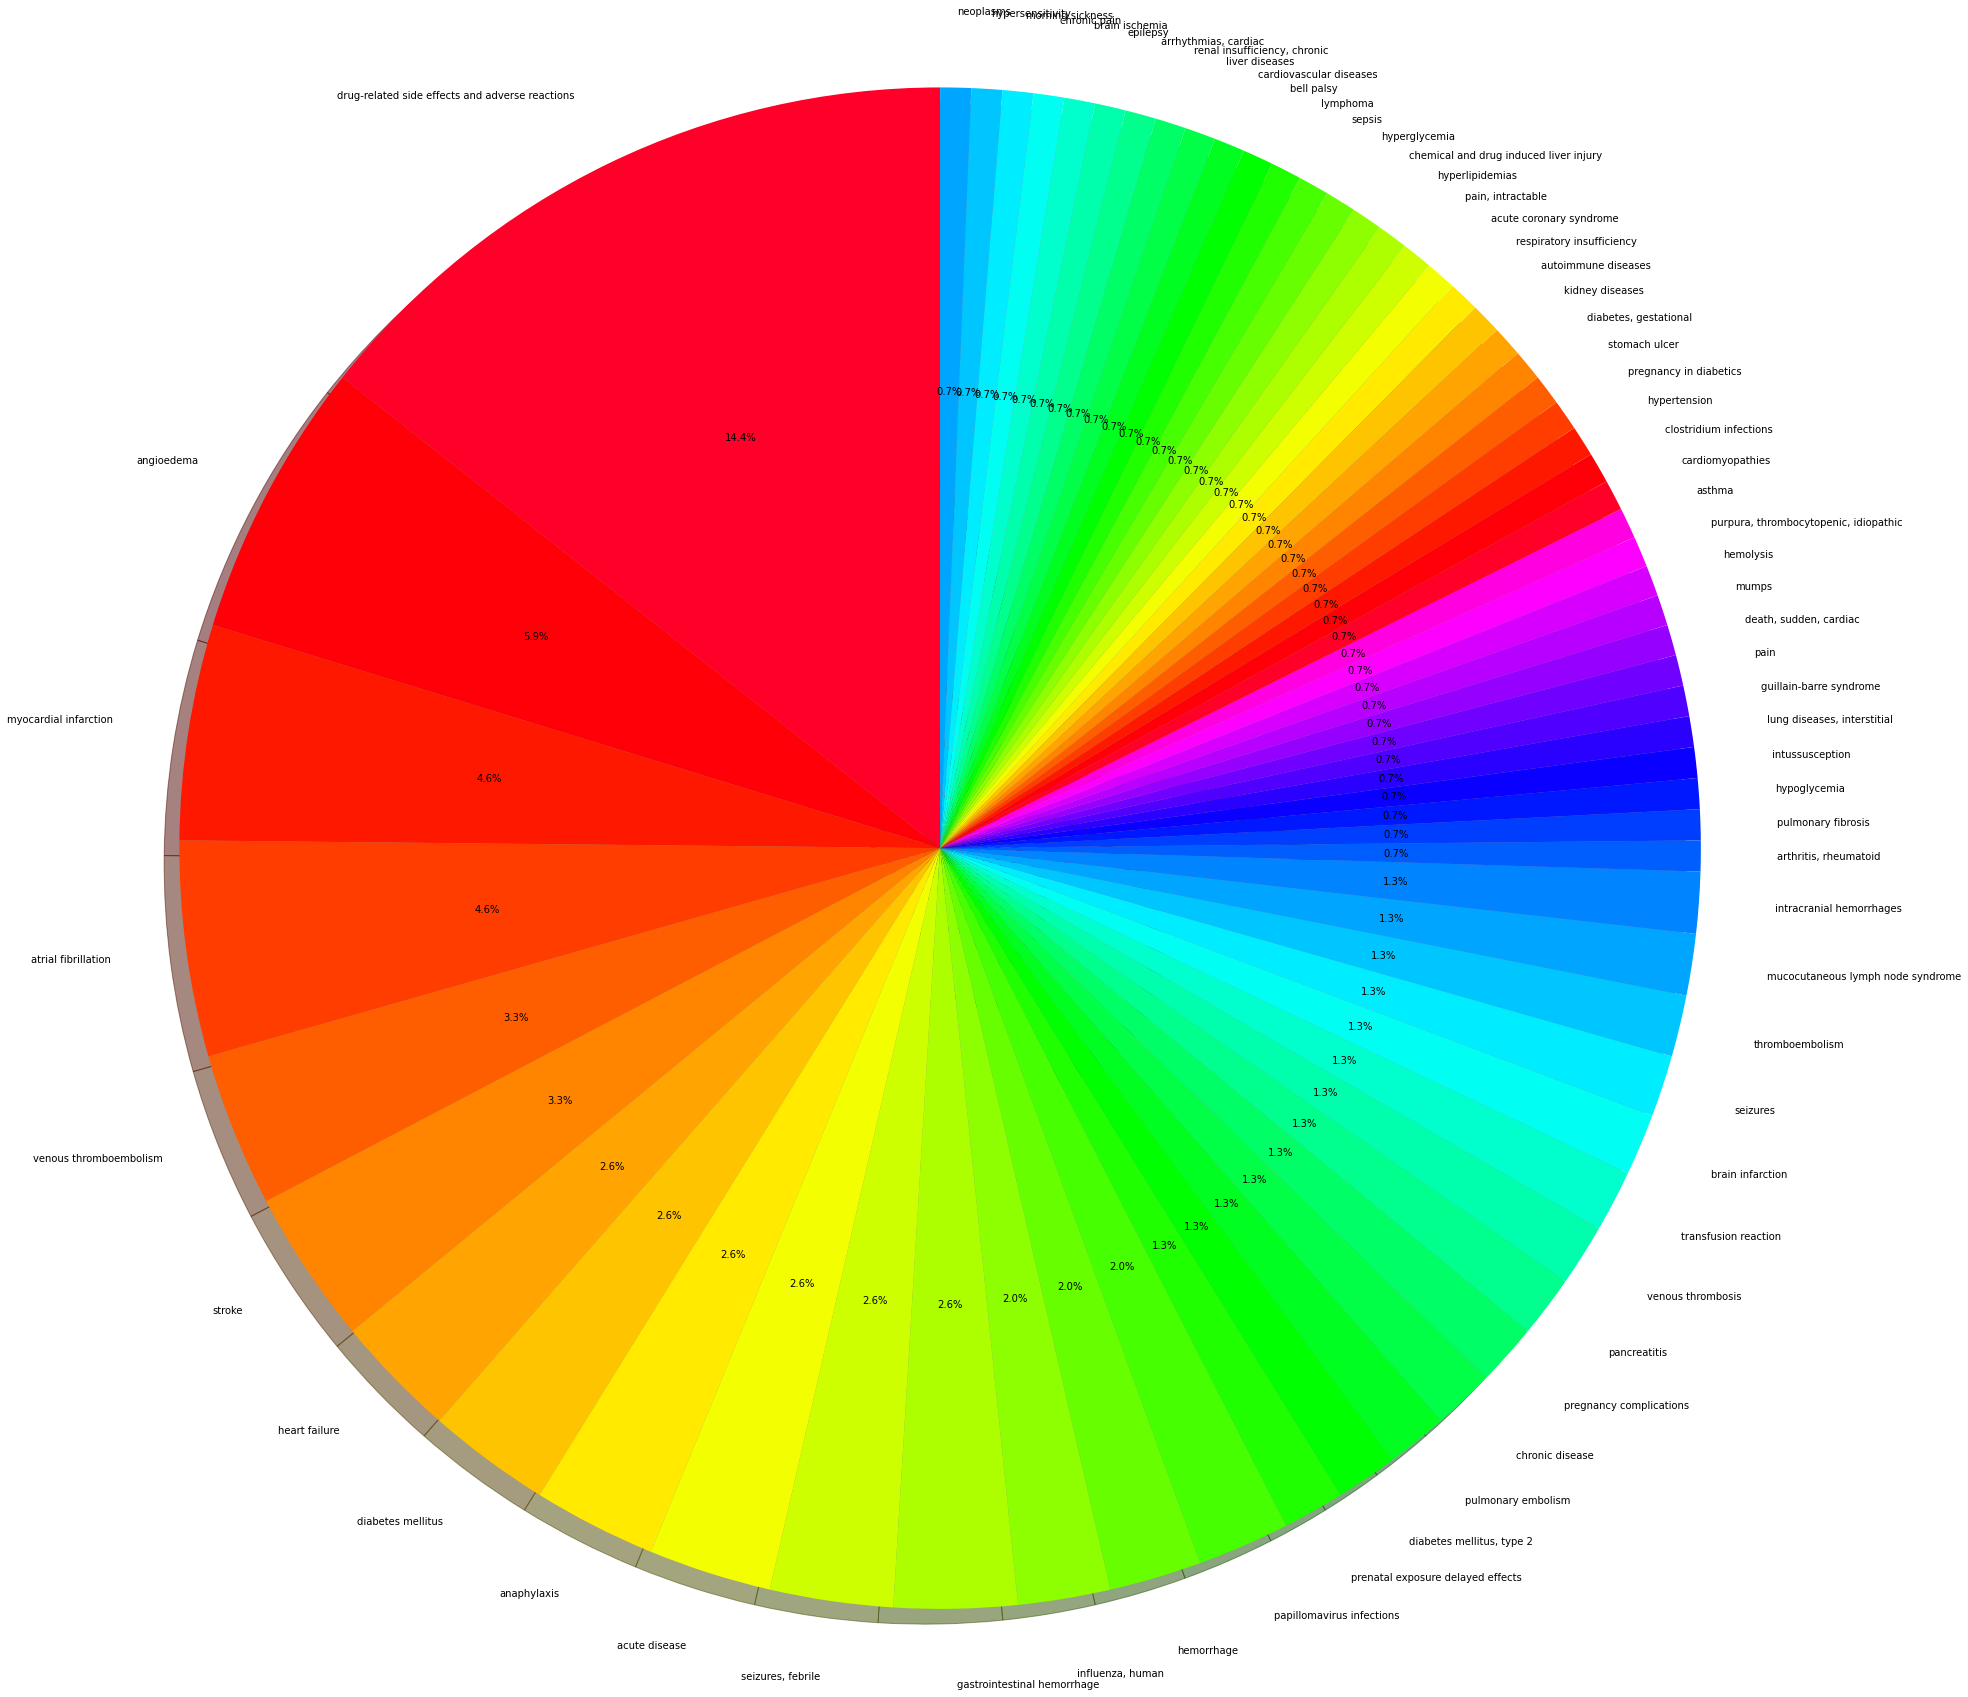

In [22]:
#Create a pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = names
sizes = sizes

cs=cm.gist_rainbow(np.arange(40)/40.)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors=cs, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)

ax1.axis('equal')
fig = plt.gcf()
fig.set_size_inches(30,30)
plt.show()